# Scripting

### In this notebook we show how to script a pipeline directly from Python
#### (i.e. not the standard way of using *pypescript* language to write config files)
Implemented *modules* can be of different nature (Python class, Python module (file), compiled module). We provide a coherent interface to all of them; they are all (if not already inherting from BaseModule) recast in a BaseModule instance. You can still access all their attributes in a standard way. You do not have to worry about that, everything is done by the custom *mimport* function below.
In this notebook we reproduce (partially) the pipeline in demo_basic.yaml: construct a DataVector instance, set some (inverse) covariance matrix (directly in the data_block) and fit using minuit.

In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt

import pypescript
from pypescript import BasePipeline, mimport
from pypescript.main import main

from cosmopipe.lib import setup_logging

setup_logging()

## Building up the pipeline

Let's first build the synthetic DataVector instance, let's say it is a constant power spectrum $P(k) = 1 \; (\mathrm{Mpc}/h)^{3}$

[000000.01] [0/1] 08-12 20:37  BaseModule                INFO     Importing module cosmopipe.data_vector.synthetic_data_vector [synthetic_data_vector].
[000000.04] [0/1] 08-12 20:37  BaseModule                INFO     Found description file /local/home/adematti/Bureau/DESI/NERSC/cosmopipe/cosmopipe/data_vector/synthetic_data_vector.yaml.
[000000.04] [0/1] 08-12 20:37  BaseModule                INFO     Init module SyntheticDataVector [synthetic_data_vector].


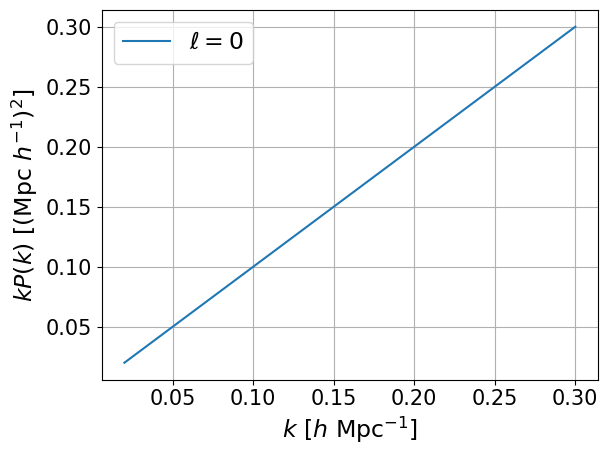

In [2]:
x = np.linspace(0.02,0.3,11)
y = np.ones_like(x)
proj = 'ell_0'
xdata = mimport('cosmopipe.data_vector.synthetic_data_vector',options={'x':x,'y':y,'projs':[proj]})

xdata.setup() # this sets up the data vector
xdata.data_block['data','data_vector'].plot(style='power')
plt.show()

Now the rest:
- model
- projection (to evaluate model at the data points)
- likelihood (to compare data and model)
- minuit (to maximize likelihood)

In [3]:
model = mimport('cosmopipe.tests.basic_model')

projection = mimport('cosmopipe.survey_selection.projection')

like = mimport('cosmopipe.likelihood.likelihood',module_class='GaussianLikelihood',options={'$modules':[xdata,model,projection]})

# n_iteraions = 5 => 5 fits
minuit = mimport('cosmopipe.samplers.profiler.minuit',options={'migrad':{'n_iterations':5},'$modules':[like]})

[000000.57] [0/1] 08-12 20:37  BaseModule                INFO     Importing module cosmopipe.tests.basic_model [basic_model].
[000000.85] [0/1] 08-12 20:37  BaseModule                INFO     Found description file /local/home/adematti/Bureau/DESI/NERSC/cosmopipe/cosmopipe/tests/basic_model.yaml.
[000000.85] [0/1] 08-12 20:37  BaseModule                INFO     Init module BasicModel [basic_model].
[000000.85] [0/1] 08-12 20:37  BaseModule                INFO     Importing module cosmopipe.survey_selection.projection [projection].
[000000.87] [0/1] 08-12 20:37  BaseModule                INFO     Found description file /local/home/adematti/Bureau/DESI/NERSC/cosmopipe/cosmopipe/survey_selection/projection.yaml.
[000000.87] [0/1] 08-12 20:37  SurveyProjection          INFO     Init module SurveyProjection [projection].
[000000.87] [0/1] 08-12 20:37  BaseModule                INFO     Importing module cosmopipe.likelihood.likelihood [likelihood].
[000000.90] [0/1] 08-12 20:37  BaseModule  

## Running the pipeline

In [4]:
# We set the inverse covariance matrix manually
minuit.data_block['covariance','invcov'] = 100
minuit.setup()
print(minuit.torun)
# Now let's run the (5) fits
minuit.execute()

[000000.96] [0/1] 08-12 20:37  GaussianLikelihood        INFO     The number of observations used to estimate the covariance matrix is not provided, hence no Hartlap factor is applied to inverse covariance.
['migrad']
[000000.97] [0/1] 08-12 20:37  MinuitProfiler            INFO     Running migrad for 5 iterations.
[000000.97] [0/1] 08-12 20:37  BaseTaskManager           INFO     Entering BaseTaskManager.


## Postprocessing

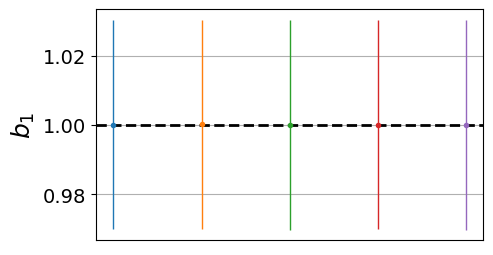

In [5]:
# One can access the output best fit from the data_block
profiles = minuit.data_block['likelihood','profiles']

from cosmopipe.lib.samples import ProfilesPlotStyle
style = ProfilesPlotStyle()
style.plot_aligned_stacked(profiles,truths=1)
plt.show()

## Running samples (emcee)
For fun, let's run samples.

In [6]:
# Using 10 walkers, stoping when Gelman-Rubin criterion < 0.01
sampler = mimport('cosmopipe.samplers.ensemble.emcee',options={'$modules':[like],'diagnostics':{'eigen_gr_stop':0.01},'nwalkers':10})
sampler.data_block['covariance','invcov'] = 100
sampler.setup()
sampler.execute()

[000001.19] [0/1] 08-12 20:37  BaseModule                INFO     Importing module cosmopipe.samplers.ensemble.emcee [emcee].
[000001.27] [0/1] 08-12 20:37  BaseModule                INFO     Found description file /local/home/adematti/Bureau/DESI/NERSC/cosmopipe/cosmopipe/samplers/ensemble/emcee.yaml.
[000001.28] [0/1] 08-12 20:37  EmceeSampler              INFO     Init module EmceeSampler [emcee].
[000001.28] [0/1] 08-12 20:37  GaussianLikelihood        INFO     The number of observations used to estimate the covariance matrix is not provided, hence no Hartlap factor is applied to inverse covariance.
[000001.28] [0/1] 08-12 20:37  EmceeSampler              INFO     Varying parameters ['galaxy_bias.b'].
[000002.00] [0/1] 08-12 20:37  EmceeSampler              INFO     Sampling has run for 200 iterations.
[000002.00] [0/1] 08-12 20:37  EmceeSampler              INFO     Diagnostics:
[000002.01] [0/1] 08-12 20:37  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.053

[000009.68] [0/1] 08-12 20:38  EmceeSampler              INFO     Sampling has run for 2000 iterations.
[000009.68] [0/1] 08-12 20:38  EmceeSampler              INFO     Diagnostics:
[000009.69] [0/1] 08-12 20:38  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.000478 < 0.01.
[000009.69] [0/1] 08-12 20:38  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.000478.
[000009.78] [0/1] 08-12 20:38  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0174.
[000009.79] [0/1] 08-12 20:38  EmceeSampler              INFO     - max Geweke statistic is 0.0309.
[000009.81] [0/1] 08-12 20:38  EmceeSampler              INFO     - max integrated autocorrelation time is 25.7 (reliable).
[000009.81] [0/1] 08-12 20:38  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.00773.


## Postprocessing samples

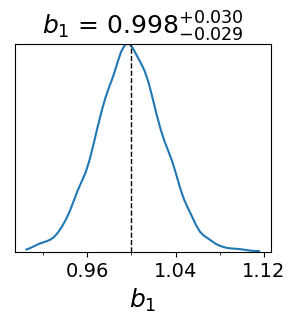

In [7]:
samples = sampler.data_block['likelihood','samples'].remove_burnin(0.5) # remove first 50% of the samples

from cosmopipe.lib.samples import SamplesPlotStyle
style = SamplesPlotStyle()
style.plot_corner(samples,truths=1)
plt.show()

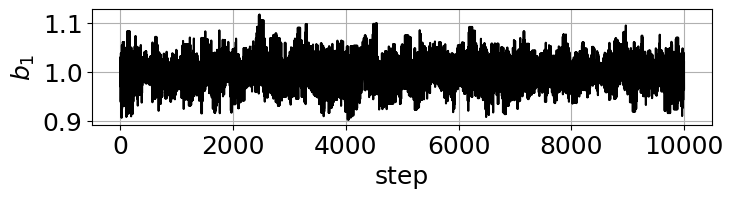

In [8]:
style.plot_chain(samples)
plt.show()

## Accessing pipeline modules

In [9]:
model = sampler.fetch_module('likelihood.basic_model') # default module names are snake case
print(model.model.basis)

ProjectionBasis(space=power,mode=multipole,projs=[0])
